<a href="https://colab.research.google.com/github/ViniSpeck/ML/blob/main/RFR_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Apresentação

**N3 - Machine Learning**

Esse notebook visa testar a performance do Random Forest Regressor na predição de valores de fechamento diário de ativos financeiros.

--------------------------------------------------------------------------------------


# Importação dos dados

In [371]:
!pip install yfinance
!pip install quandl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [372]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()
import quandl as q
from matplotlib import pyplot as plt
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error


In [373]:
# Definindo parâmetros 
ticker = 'BTC-USD'
sp500_ticker = '^GSPC'
start_date = '2015-06-01'

# Extraindo dados do token/ação desejada
df_ticker = pdr.get_data_yahoo(ticker, start=start_date) #end_time padrão é hoje

# Extraindo dados do S&P 500 (Valores médios dos 500 ativos 'melhores' cotados na NASDAQ)
df_sp500 = pdr.get_data_yahoo(sp500_ticker, start=start_date)

# Extraindo dados da tesouraria americana (Feature de correlação com Renda Fixa)
treasury = q.get('USTREASURY/YIELD', trim_start=start_date, returns='pandas', api_key='CxiCzqzjsPoa7sSBvCDh')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Tratamento dos dados

In [374]:
df_sp500.rename(columns={'Open':'S&P Open', 'High':'S&P High', 'Low':'S&P Low', 'Close':'S&P Close', 'Adj Close':'S&P Adj Close', 'Volume':'S&P Volume'},inplace=True)
df = pd.concat([df_ticker, df_sp500, treasury['1 MO']], axis=1)

In [375]:
print("Formato (Linhas, Colunas): ", df.shape)
print("Colunas (Variáveis): ", df.columns)
print("Existe algum valor 'NaN': ", df.isnull().values.any())
print("Existem valores duplicados: ", df.index.duplicated().any())

Formato (Linhas, Colunas):  (2745, 13)
Colunas (Variáveis):  Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'S&P Open',
       'S&P High', 'S&P Low', 'S&P Close', 'S&P Adj Close', 'S&P Volume',
       '1 MO'],
      dtype='object')
Existe algum valor 'NaN':  True
Existem valores duplicados:  False


In [376]:
# Se houverem valores 'NaN' eles tem que ser substituídos.
# O volume é um evento diário independente, portanto será substituído por zeros
df['Volume'].fillna(value=0, inplace=True)
df['S&P Volume'].fillna(value=0, inplace=True)

# Os valores de OHLC, por outro lado, são dependentes e relacionados ao dia seguinte e anterior
# então será substituído por interpolação linear (média do dia anterior e seguinte ao 'NaN')
df.interpolate(inplace=True)

# Se ainda tiver algum valor 'NaN', faremos uma substituição convencional por backwards fill (utilizar o valor do dia anterior)
df=df.bfill()

In [377]:
# Visão geral do estado dos dados
print("Formato (Linhas, Colunas): ", df.shape)
print("Colunas (Variáveis): ", df.columns)
print("Existe algum valor 'NaN': ", df.isnull().values.any())
print("Existem valores duplicados: ", df.index.duplicated().any())

Formato (Linhas, Colunas):  (2745, 13)
Colunas (Variáveis):  Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'S&P Open',
       'S&P High', 'S&P Low', 'S&P Close', 'S&P Adj Close', 'S&P Volume',
       '1 MO'],
      dtype='object')
Existe algum valor 'NaN':  False
Existem valores duplicados:  False


In [378]:
# Criando features do histórico dos dados
df_hist = df
for i in range(1,8): # periodo semanal
    df_hist["Open -"+str(i)] = df_hist['Open'].shift(i)
    df_hist["High -"+str(i)] = df_hist['High'].shift(i)
    df_hist["Low -"+str(i)]  = df_hist['Low'].shift(i)
    df_hist["Close -"+str(i)]= df_hist['Close'].shift(i)
    df_hist["Adj Close -"+str(i)] = df_hist['Adj Close'].shift(i)
    df_hist["Volume -"+str(i)] = df_hist['Volume'].shift(i)
    df_hist["S&P Open -"+str(i)] = df_hist['S&P Open'].shift(i)
    df_hist["S&P High -"+str(i)] = df_hist['S&P High'].shift(i)
    df_hist["S&P Low -"+str(i)]  = df_hist['S&P Low'].shift(i)
    df_hist["S&P Close -"+str(i)]= df_hist['S&P Close'].shift(i)
    df_hist["S&P Adj Close -"+str(i)] = df_hist['S&P Adj Close'].shift(i)
    df_hist["S&P Volume -"+str(i)] = df_hist['S&P Volume'].shift(i)
    df_hist["1 MO -"+str(i)] = df_hist['1 MO'].shift(i)

df_hist = df_hist.dropna() # dropar as primeiras linhas do dataset que não têm histórico
print("Formato do Dataframe com Histórico: ", df_hist.shape)
df_hist.tail()


Formato do Dataframe com Histórico:  (2738, 104)


,Open,High,Low,Close,Adj Close,Volume,S&P Open,S&P High,S&P Low,S&P Close,...,Close -7,Adj Close -7,Volume -7,S&P Open -7,S&P High -7,S&P Low -7,S&P Close -7,S&P Adj Close -7,S&P Volume -7,1 MO -7
Date,,,,,,,,,,,,,,,,,,,,,
2022-12-01,17168.001953,17197.498047,16888.388672,16967.132812,16967.132812,22895392882,4087.139893,4100.509766,4050.870117,4076.570068,...,16604.464844,16604.464844,2.612904e+10,4011.820068,4033.900024,4009.709961,4026.690063,4026.690063,0.000000e+00,4.140000
2022-12-02,16968.683594,17088.660156,16877.880859,17088.660156,17088.660156,19539705127,4040.169922,4080.479980,4026.629883,4071.699951,...,16521.841797,16521.841797,1.867826e+10,4023.340088,4034.020020,4020.760010,4026.120117,4026.120117,1.706460e+09,4.160000
2022-12-03,17090.097656,17116.041016,16888.140625,16908.236328,16908.236328,16217776704,4040.169922,4080.479980,4026.629883,4071.699951,...,16464.281250,16464.281250,1.800001e+10,4017.346761,4026.770020,3999.096680,4005.393392,4005.393392,0.000000e+00,4.143333
2022-12-04,16908.169922,17157.767578,16903.439453,17130.486328,17130.486328,16824520830,4040.169922,4080.479980,4026.629883,4071.699951,...,16444.626953,16444.626953,2.044390e+10,4011.353434,4019.520020,3977.433350,3984.666667,3984.666667,0.000000e+00,4.126667
2022-12-05,17106.041016,17378.152344,17102.419922,17328.201172,17328.201172,19980777472,4040.169922,4080.479980,4026.629883,4071.699951,...,16217.322266,16217.322266,2.774303e+10,4005.360107,4012.270020,3955.770020,3963.939941,3963.939941,3.615430e+09,4.110000


In [379]:
# Adicionando a coluna de rótulo (fechamento no dia seguinte)
df_hist['Next Close'] = df_hist['Adj Close'].shift(-1)
df_hist = df_hist.dropna() # Removendo a linha do dia atual (Sem dados do próximo fechamento)
print("Novo formato com a coluna de rotulagem:", df_hist.shape)
df_hist.tail()

Novo formato com a coluna de rotulagem: (2737, 105)


<ipython-input-379-7bedfaadfc3d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hist['Next Close'] = df_hist['Adj Close'].shift(-1)


,Open,High,Low,Close,Adj Close,Volume,S&P Open,S&P High,S&P Low,S&P Close,...,Adj Close -7,Volume -7,S&P Open -7,S&P High -7,S&P Low -7,S&P Close -7,S&P Adj Close -7,S&P Volume -7,1 MO -7,Next Close
Date,,,,,,,,,,,,,,,,,,,,,
2022-11-30,16445.476562,17190.937500,16445.476562,17168.566406,17168.566406,29523576583,3957.179932,4080.110107,3938.580078,4080.110107,...,16610.707031,3.295888e+10,4000.300049,4033.780029,3998.659912,4027.260010,4027.260010,3.279720e+09,4.120000,16967.132812
2022-12-01,17168.001953,17197.498047,16888.388672,16967.132812,16967.132812,22895392882,4087.139893,4100.509766,4050.870117,4076.570068,...,16604.464844,2.612904e+10,4011.820068,4033.900024,4009.709961,4026.690063,4026.690063,0.000000e+00,4.140000,17088.660156
2022-12-02,16968.683594,17088.660156,16877.880859,17088.660156,17088.660156,19539705127,4040.169922,4080.479980,4026.629883,4071.699951,...,16521.841797,1.867826e+10,4023.340088,4034.020020,4020.760010,4026.120117,4026.120117,1.706460e+09,4.160000,16908.236328
2022-12-03,17090.097656,17116.041016,16888.140625,16908.236328,16908.236328,16217776704,4040.169922,4080.479980,4026.629883,4071.699951,...,16464.281250,1.800001e+10,4017.346761,4026.770020,3999.096680,4005.393392,4005.393392,0.000000e+00,4.143333,17130.486328
2022-12-04,16908.169922,17157.767578,16903.439453,17130.486328,17130.486328,16824520830,4040.169922,4080.479980,4026.629883,4071.699951,...,16444.626953,2.044390e+10,4011.353434,4019.520020,3977.433350,3984.666667,3984.666667,0.000000e+00,4.126667,17328.201172


In [385]:
# Dividindo os conjuntos de treino e teste
prediction_days = 150
df_train = df_hist[:len(df_hist) - prediction_days ]
df_test  = df_hist[ len(df_hist) - prediction_days:]

training_set = df_train.values
X_train = training_set[0:len(training_set), 0:df_hist.shape[1]]
y_train = training_set[0:len(training_set), df_hist.shape[1]-1].reshape(-1,1)

test_set = df_test.values
X_test = test_set[0:len(test_set), 0:df_hist.shape[1]]
y_test = test_set[0:len(test_set), df_hist.shape[1]-1].reshape(-1,1)

df_train.head(3)

,Open,High,Low,Close,Adj Close,Volume,S&P Open,S&P High,S&P Low,S&P Close,...,Adj Close -7,Volume -7,S&P Open -7,S&P High -7,S&P Low -7,S&P Close -7,S&P Adj Close -7,S&P Volume -7,1 MO -7,Next Close
Date,,,,,,,,,,,,,,,,,,,,,
2015-06-08,222.878998,229.464005,222.839005,228.488998,228.488998,23378400,2092.340088,2093.010010,2079.110107,2079.280029,...,222.925995,26090500.0,2108.639893,2119.149902,2102.540039,2111.729980,2111.729980,3.011710e+09,0.02,229.048004
2015-06-09,228.537994,230.953995,227.929001,229.048004,229.048004,28353100,2079.070068,2085.620117,2072.139893,2080.149902,...,225.802994,20459000.0,2110.409912,2117.590088,2099.139893,2109.600098,2109.600098,3.049350e+09,0.02,228.802994
2015-06-10,228.994995,229.781998,228.009995,228.802994,228.802994,15904800,2081.120117,2108.500000,2081.120117,2105.199951,...,225.873993,17752400.0,2110.639893,2121.919922,2109.610107,2114.070068,2114.070068,3.099980e+09,0.02,229.705002


# Modelo de Machine Learning

In [386]:
rf = RandomForestRegressor(random_state = 5)
rf.fit(X_train, np.ravel(y_train));
predictions = rf.predict(X_test)

In [387]:
# Definição de métricas
print('MAE: ', mean_absolute_error(y_true=y_test, y_pred=predictions))
print('RMSE: ', np.sqrt(mean_squared_error(y_true=y_test, y_pred=predictions)))
print('R2 Score: ', r2_score(y_true=y_test, y_pred=predictions))

MAE:  140.60662903645832
RMSE:  225.43324301518194
R2 Score:  0.9894797286941736


In [388]:
df_Result = pd.DataFrame(y_test, index=df_test.index, columns=["Next Close"])
df_Result['Predicted'] = predictions
df_Result.tail()


,Next Close,Predicted
Date,,
2022-11-30,16967.132812,16920.719824
2022-12-01,17088.660156,17143.508027
2022-12-02,16908.236328,16823.325518
2022-12-03,17130.486328,17176.809424
2022-12-04,17328.201172,17560.439395


#Visualização dos resultados

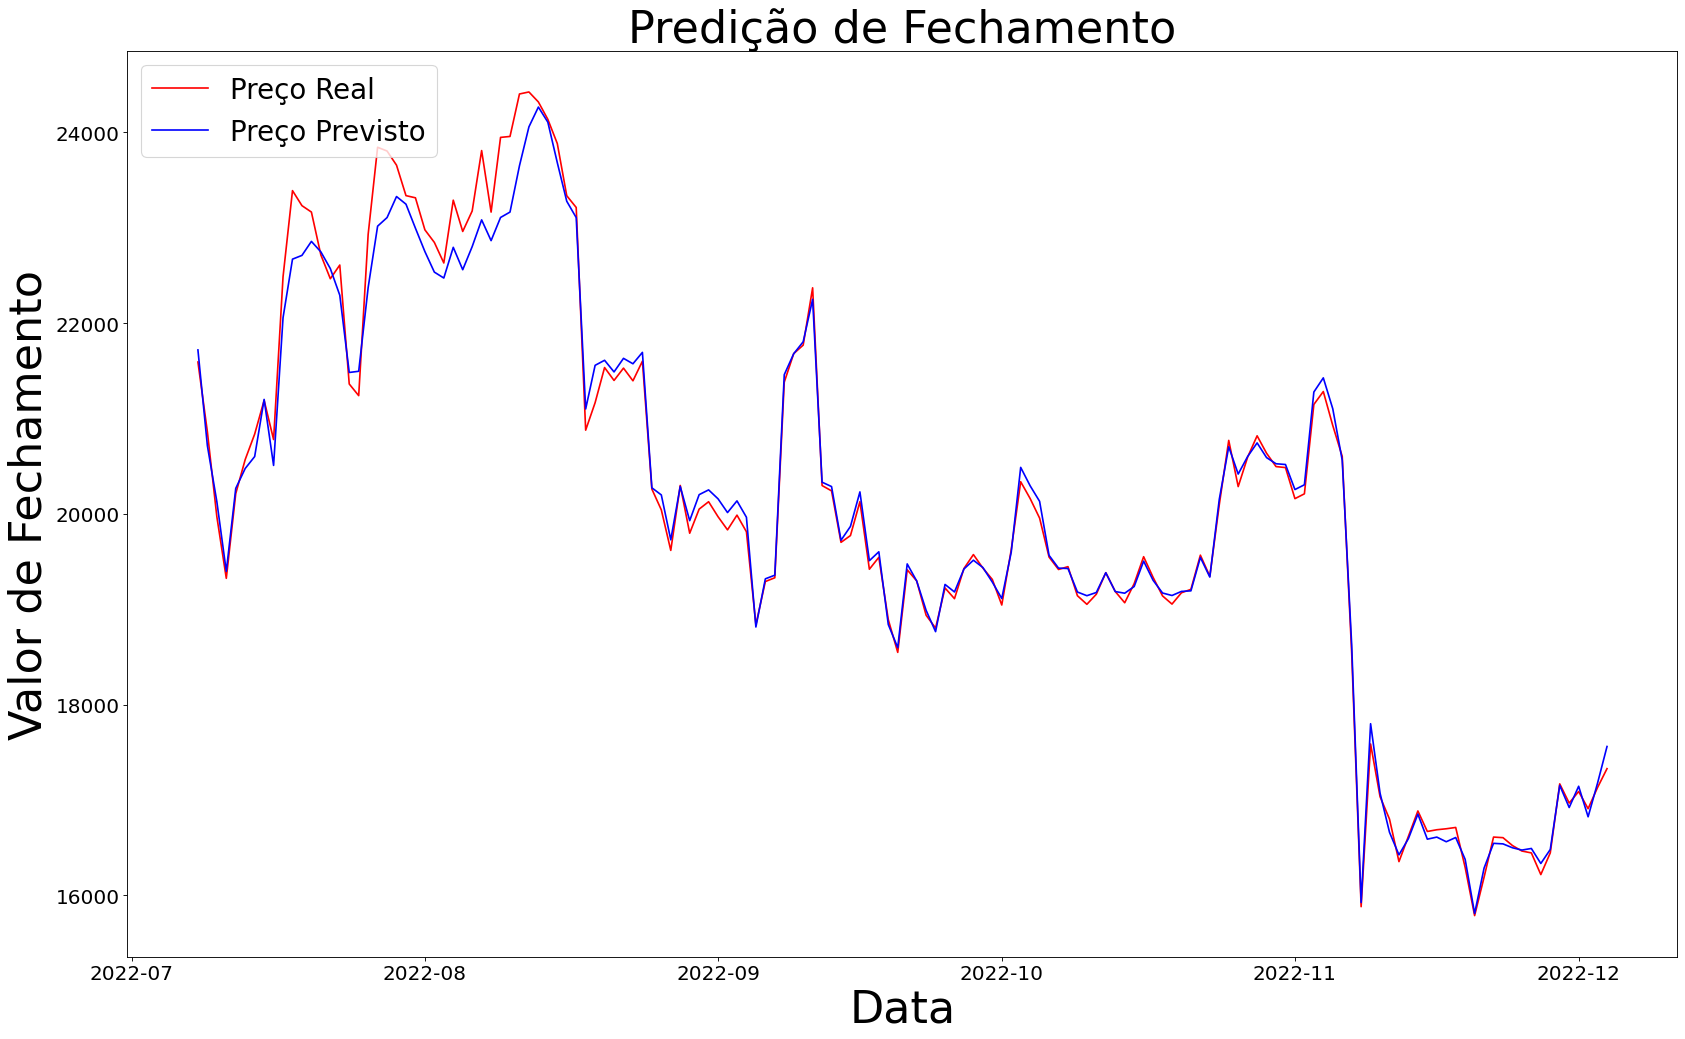

In [389]:
plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  
plt.plot(df_Result['Next Close'], color = 'red', label = 'Preço Real')
plt.plot(df_Result['Predicted'], color = 'blue', label = 'Preço Previsto')
plt.title('Predição de Fechamento', fontsize=40)
df_test = df_Result.reset_index()
x = df_test.index
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
plt.xlabel('Data', fontsize=40)
plt.ylabel('Valor de Fechamento', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
plt.show()


# Referências

https://www.kaggle.com/code/tomwarrens/timeseriessplit-how-to-use-it/notebook

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

https://colab.research.google.com/drive/16qyiHOXDPtxBZlQvNHAJU_P6Wu8_np5f

https://github.com/ykpgrr/Price-Prediction-with-Random-Forest/blob/master/Bitcoin%20Price%20Prediction%20with%20Scikit-Learn%20using%20Random%20Forest.ipynb